In [1]:
from qaoa_and_tdvp import QAOA, tdvp_optimize_qaoa, scipy_optimize, QAOAResult, Qobj, gradient_descent, gen_grad, \
    finitediff, qaoa_tdvp_rhs, finitediff_serial
from MaxCut import MaxCut
from qutip import tensor
from qutip.qip.operations import expand_operator, rz
from benchmark import get_all_connected, get_connected_rn_graph, get_rn_qubo, select_if_connected, Benchmark
from qutip.parallel import parallel_map, serial_map
import networkx as nx
from itertools import combinations_with_replacement
from multiprocessing import Value
import pickle
import numpy as np
from scipy.integrate import solve_ivp

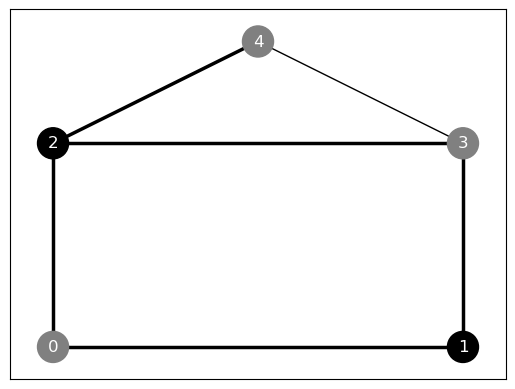

In [2]:
house = nx.house_graph()
nx.draw_networkx(
    house,
    node_size=500,
    with_labels=True,
    node_color=["grey", "black", "black", "grey", "grey"],
    font_color="white",
    width=[2.5, 2.5, 2.5, 2.5, 2.5, 1],
    pos={0: (0, 0), 1: (1, 0), 2: (0, 1), 3: (1, 1), 4: (0.5, 1.5)},
)


In [3]:
p = 1
n=4
seed = 42
with open(f"./instances/n{n}_instances.p","rb") as f:
    maxcuts = pickle.load(f)

In [4]:
index = 5#np.random.randint(0,len(graphs)); print(index)
maxcuts[index]

In [5]:
qaoa = QAOA(qubo=maxcuts[index].qubo, p=p)
delta = tuple(1 for _ in range(2 * qaoa.p))

In [6]:
# descent = gradient_descent(qaoa, delta)

In [7]:
res = tdvp_optimize_qaoa(qaoa, delta, num_of_path_points=20, Delta=100, int_mode="RK45", grad_tol=.5)
res

donestep 39

(0.8019971376736641, 1.2263223460629114)



        tdvp_optimizer with circuit gradient evaluation and RK45 as integration mode terminated with sucess with message
        "A termination event occurred."
        This took 12.87 seconds
        
            optimal parameters: (0.8019971376736641, 1.2263223460629114)
                 optimal value: -4.141483187239213
           number of fun calls: 26
               number of steps: 39
        

In [8]:
res.parameter_path

[(1.0, 1.0),
 (1.0020779855444848, 1.046188676558675),
 (0.8708880341359726, 1.1859926015389342),
 (0.8019971376736641, 1.2263223460629114)]

In [8]:
res.parameter_path

[(1.0, 1.0),
 (1.1463536671199428, 1.0537054136855457),
 (1.1506612811462984, 1.0552356933947746),
 (1.1506612811462984, 1.0552356933947746),
 (1.2518654901910875, 1.0900151240755316),
 (1.3638969774569887, 1.1241317653860428),
 (1.3638969774569887, 1.1241317653860428),
 (1.4444004641343304, 1.1440399699587085),
 (1.6372744968459556, 1.1711197169198957),
 (1.6372744968459556, 1.1711197169198957),
 (1.7101083259775787, 1.1731955036555564),
 (1.9768184815746197, 1.1261910972979925),
 (1.9768184815746197, 1.1261910972979925),
 (2.0156439932594012, 1.108166290665415),
 (2.117819120962312, 1.0280694719336951),
 (2.198470171962537, 0.9594111033806103),
 (2.238724350954454, 0.9316264604501521),
 (2.238724350954454, 0.9316264604501521),
 (2.259308260524988, 0.9187760006934755),
 (2.3447742527819164, 0.876815461363841),
 (2.392817545467251, 0.8581790312692867),
 (2.4169330916403733, 0.8499053746455918),
 (2.4252271175351092, 0.846928180453121),
 (2.4252271175351092, 0.846928180453121),
 (2.4285

In [9]:
sci_res = scipy_optimize(qaoa, delta, tol=.01, record_path=True)

Done Scipy_optim



In [10]:
sci_res.parameter_path

[(1, 1),
 (2.0, 1.0),
 (2.0, 2.0),
 (2.8923031772452505, 0.5485633600625317),
 (2.4461515886226253, 0.7742816800312659),
 (2.4704778664446576, 0.2748737984281365),
 (2.693144875841007, 1.2090164452261578),
 (2.397804640150067, 0.5290010803634735),
 (2.334440716806775, 0.8303680519779583),
 (2.3624839027801214, 0.8862234878858832),
 (2.308902538492321, 0.9991572622895488),
 (2.423564828029802, 0.8729807324836656),
 (2.4385744383763233, 0.9003901122148013),
 (2.4245717777333033, 0.8417469598601957),
 (2.4080626407829855, 0.8749359346636555),
 (2.423030545571803, 0.8629950155712414),
 (2.4273579913594228, 0.8539798498514549),
 (2.4273579913594228, 0.8539798498514549),
 array([2.42735799, 0.85397985])]

In [ ]:
fast_gram = qaoa.gram(delta)

In [ ]:
%timeit qaoa.gram(delta)

In [ ]:
fast_grad = qaoa.grad(delta)

In [ ]:
%timeit qaoa.grad(delta)

In [ ]:
qaoa._Gij = qaoa._Gij_unitary
qaoa._grad_element = qaoa._grad_element_unitary

slow_gram = qaoa.gram(delta)
slow_grad = qaoa.grad(delta)
# %timeit qaoa.gram(delta)

qaoa._Gij  = qaoa._Gij_fast
qaoa._grad_element = qaoa._grad_element_fast

The cheating method for computing the metric is roughly 33 times faster for n=4, p=2

In [ ]:
print(np.isclose(slow_gram,fast_gram))

In [ ]:
print(qaoa._Gij_fast((6,2*p),delta))
print(qaoa._Gij_unitary((6,2*p),delta))

In [ ]:
print(np.isclose(slow_grad,fast_grad))

In [ ]:
res = tdvp_optimize_qaoa(
    qaoa,
    delta,
    1,
    int_mode="RK45",
    rhs_mode="qaoa",
    grad_tol=0.1,
    max_iter=300,
)
print(res)

In [ ]:
sci_res = scipy_optimize(qaoa, delta)
sci_res